In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# fix random seed for reproducibility
np.random.seed(7)


In [24]:
# load the dataset
dataframe = pd.read_csv('../Data/temp_clean.csv', usecols=[1])
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [25]:
dataframe.head()

,Avg_anomalies
0,-0.29
1,-0.18
2,-0.11
3,-0.20
4,-0.12


In [26]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1117 551


In [28]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [29]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))# reshape into X=t and Y=t+1


In [30]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1115/1115 - 5s - loss: 0.0127 - 5s/epoch - 4ms/step
Epoch 2/100
1115/1115 - 2s - loss: 0.0046 - 2s/epoch - 2ms/step
Epoch 3/100
1115/1115 - 2s - loss: 0.0035 - 2s/epoch - 2ms/step
Epoch 4/100
1115/1115 - 2s - loss: 0.0031 - 2s/epoch - 2ms/step
Epoch 5/100
1115/1115 - 2s - loss: 0.0030 - 2s/epoch - 2ms/step
Epoch 6/100
1115/1115 - 2s - loss: 0.0030 - 2s/epoch - 2ms/step
Epoch 7/100
1115/1115 - 2s - loss: 0.0030 - 2s/epoch - 1ms/step
Epoch 8/100
1115/1115 - 2s - loss: 0.0030 - 2s/epoch - 2ms/step
Epoch 9/100
1115/1115 - 2s - loss: 0.0030 - 2s/epoch - 2ms/step
Epoch 10/100
1115/1115 - 2s - loss: 0.0030 - 2s/epoch - 2ms/step
Epoch 11/100
1115/1115 - 3s - loss: 0.0030 - 3s/epoch - 2ms/step
Epoch 12/100
1115/1115 - 2s - loss: 0.0030 - 2s/epoch - 2ms/step
Epoch 13/100
1115/1115 - 2s - loss: 0.0030 - 2s/epoch - 2ms/step
Epoch 14/100
1115/1115 - 2s - loss: 0.0029 - 2s/epoch - 2ms/step
Epoch 15/100
1115/1115 - 2s - loss: 0.0030 - 2s/epoch - 2ms/step
Epoch 16/100
1115/1115 - 2s - loss

In [31]:
testX

array([[[0.5162791 ]],

       [[0.4976744 ]],

       [[0.49302325]],

       [[0.49302325]],

       [[0.45581394]],

       [[0.41860464]],

       [[0.3860465 ]],

       [[0.41860464]],

       [[0.4372093 ]],

       [[0.4       ]],

       [[0.34418604]],

       [[0.30232558]],

       [[0.24186046]],

       [[0.3488372 ]],

       [[0.32093024]],

       [[0.3627907 ]],

       [[0.34418604]],

       [[0.3534884 ]],

       [[0.4232558 ]],

       [[0.32093024]],

       [[0.33488372]],

       [[0.33953488]],

       [[0.33023256]],

       [[0.40465117]],

       [[0.40465117]],

       [[0.43255812]],

       [[0.39534885]],

       [[0.44651163]],

       [[0.37674418]],

       [[0.36744186]],

       [[0.28372094]],

       [[0.35813954]],

       [[0.33023256]],

       [[0.29767442]],

       [[0.29302326]],

       [[0.36744186]],

       [[0.34418604]],

       [[0.2744186 ]],

       [[0.33488372]],

       [[0.26046512]],

       [[0.29767442]],

       [[0.32558

18/18 [==============================] - 0s 980us/step


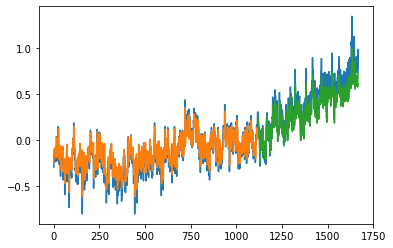

In [17]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()